## Part 1: Introduction

In this series I am deriving the self-attention mechansim introduced in the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762).
Attention as communication mechanism builds the performance foundation for transformer models and is therefore at the heart of modern deep learning.
To this end I think every good machine learning engineer (What I am trying to become :D) should have derived/programmed attention from scratch at least once.

A very useful source for this is in my opinion the [build-GPT video](https://www.youtube.com/watch?v=kCc8FmEb1nY) from Andrej Karpathy, 
who delivers a great intutition about what makes attention so special.
So this series is essentially me following the steps of the tutorial and adding some own comments and stylistic elements here and there.


### What makes attention special?

Attention mechanisms solve a fundamental problem in sequence modeling: how can we effectively capture relationships between elements in a sequence, regardless of their distance? While traditional approaches like RNNs struggled with long-range dependencies, attention allows direct communication between any elements in a sequence, making it incredibly powerful for tasks, such as, Language modeling, Machine translation, Document understanding.

### Exploring Our Data

In his video, Andrej Karpathy derives attention from the attempt to train a language model that can generate Shakespeare-like text.
For this he uses a corpus that holds the plays written by Shakespeare.

In [1]:
# Download dataset to train on
!curl.exe --output shakespeare.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1089k  100 1089k    0     0  3805k      0 --:--:-- --:--:-- --:--:-- 3821k


In [2]:
with open('shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    
# unique chars 
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


### Character-Level Tokenizer

From the set of unique chars we can create a simple character-level tokenizer that encodes each character to a unique identifier.
We will use this to encode the whole dataset and create a train and validation split.

In [3]:
# Create in a mapping which will be used as a dummy tokenizer for character level encoding
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [4]:
# Encode dataset
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)

# Generate train and test split
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

torch.Size([1115394]) torch.int64


### Training Data Generation

We want to train a model that can generate Shakespeare-like text. 
In machine learning terms this means autoregressive modelling, where based on an input the model should generate new text.

Mathematically this can be described like this:
P(x₁, x₂, ..., xₙ) = P(x₁) × P(x₂|x₁) × P(x₃|x₁,x₂) × ... × P(xₙ|x₁,...,xₙ₋₁)

Which in essence means:
- First, we predict the probability of the first character
- Then, given the first character, predict the second
- Then, given the first two characters, predict the third
- And so on...

Given this intuition let's see how we can construct training samples for this task:

In [5]:
# The block_size determines how many text units (characters in our case) are passed in one sample, e.g. 8 in this case
block_size = 8

# We can use one sample to actually generate n = block_size - 1 samples for training
# (This way the model learns to generate text given variable sized inputs)

def describe_sample(x,y):
    for t in range(block_size):
        context = x[:t+1]
        target = y[t]
        print(f"when input is {context} try to predict: {target}")
        
x = train_data[:block_size]
y = train_data[1:block_size+1]
describe_sample(x,y)


when input is tensor([18]) try to predict: 47
when input is tensor([18, 47]) try to predict: 56
when input is tensor([18, 47, 56]) try to predict: 57
when input is tensor([18, 47, 56, 57]) try to predict: 58
when input is tensor([18, 47, 56, 57, 58]) try to predict: 1
when input is tensor([18, 47, 56, 57, 58,  1]) try to predict: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) try to predict: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) try to predict: 58


As was shown above we extract a snippet of n tokens from our training data and then use it to construct n training samples from it.
This approach useful because the model should learn to generate new text not only when it is given n tokens it advance, but also when it is given tokens in the range from 1 to n (more flexibility).

Further, during training we actually don't just want to pass a single sample, but train with multiple samples in parallel independently.
So let's create a function that creates us a batch of these above samples by taking multiple random snipptes from the encoded text corpus and then preparing them in the same way as above.

In [6]:
batch_size = 4
block_size = 8

def get_batch(split):
    data = train_data if split == 'train' else val_data
    idxs = torch.randint(len(data) - block_size, size=(batch_size,))
    x = torch.stack([data[i:i + block_size] for i in idxs])
    y = torch.stack([data[i+1:i+block_size+1] for i in idxs])
    return x,y  

In [7]:
x_b, y_b = get_batch('train)')

# Check every sample in the batch as before:
for i, (x_s, y_s) in enumerate(zip(x_b, y_b)):
    print(f"Sample number: {i}")
    describe_sample(x_s, y_s)

Sample number: 0
when input is tensor([11]) try to predict: 1
when input is tensor([11,  1]) try to predict: 39
when input is tensor([11,  1, 39]) try to predict: 52
when input is tensor([11,  1, 39, 52]) try to predict: 42
when input is tensor([11,  1, 39, 52, 42]) try to predict: 1
when input is tensor([11,  1, 39, 52, 42,  1]) try to predict: 58
when input is tensor([11,  1, 39, 52, 42,  1, 58]) try to predict: 46
when input is tensor([11,  1, 39, 52, 42,  1, 58, 46]) try to predict: 43
Sample number: 1
when input is tensor([6]) try to predict: 1
when input is tensor([6, 1]) try to predict: 50
when input is tensor([ 6,  1, 50]) try to predict: 53
when input is tensor([ 6,  1, 50, 53]) try to predict: 52
when input is tensor([ 6,  1, 50, 53, 52]) try to predict: 45
when input is tensor([ 6,  1, 50, 53, 52, 45]) try to predict: 1
when input is tensor([ 6,  1, 50, 53, 52, 45,  1]) try to predict: 46
when input is tensor([ 6,  1, 50, 53, 52, 45,  1, 46]) try to predict: 43
Sample number

### Training a Bigram Model with this data

Before diving into the complexity of the attention mechanism we will start with the simplest form of autoregressive language model: the bigram model. While it is basic, it introduces key concepts we will build upon:

- How do you make preditions based on context?
- How do you handle sequential data?
- How do you generate text autoregressively?


#### Let's implement a Bigram Model

A bigram model makes a simplifying assumption: the next character only depends on the previous character. 
Mathematically, this means:
P(x₁, x₂, ..., xₙ) = P(x₁) × P(x₂|x₁) × P(x₃|x₂) × ... × P(xₙ|xₙ₋₁)
(Important: This differs from the earlier formulation where each prediction could use all previous context!)

Let's implement it and the comments in the file will explain the key concepts:

In [8]:

import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(num_embeddings=vocab_size,embedding_dim=vocab_size)
        # The embedding table is a learnable table that creates a mapping for each token into a vector of a certain dimension (C = 65 in our case)
        # In our bigram model, these vectors represents the "logits" (raw scores) for
        # predicting the next token. 
        # (Intuitively you could a character's "preferences" for what should follow it)
        
    def forward(self, inputs: torch.tensor, targets=None):
        # inputs: (Batch, Time)
        # outputs: (Batch, Time, Channel) where Channel = vocab_size
        
        # example:
        #   inputs: "hell"
        #   targets: "ello"

        logits = self.token_embedding_table(inputs) # (B,T,C)
        # For each position in each sequence, look up the corresponding row in the embedding table
        # This gives us scores for what token should follow each input token
        
        if targets is None:
            loss = None
        else:
            # Reshape for cross entropy
            B, T, C = logits.shape
            logits = logits.view(B*T, C)    # shape: (B*T, C)
            targets = targets.view(B*T)      # shape: (B*T)
            loss = F.cross_entropy(logits, targets)
            
        return logits, loss
    
    def generate(self, inputs, max_new_tokens):
        # Generate one token at a time
        for _ in range(max_new_tokens):
            # Get predictions
            logits, _ = self(inputs)  # shape: (B,T,C)
            # For generation, we only need the predictions from the last position
            logits = logits[:, -1 , :] # becomes (B,C)
            # We convert scores to probabilities using softmax
            probs = F.softmax(logits, dim=-1)  # shape: (B,C)
            # Sample from the probability distribution to get the next token
            inputs_next = torch.multinomial(probs, num_samples=1)  # shape: (B,1)
            # Append the new token to our sequence
            inputs = torch.cat((inputs, inputs_next), dim=1)  # shape: (B,T+1)
        return inputs
    
model = BigramLanguageModel(vocab_size=vocab_size)

In [9]:
# If we now generate text with the untrained model we get glibberish
print(decode(model.generate(inputs=torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


#### Let's train the Bigram model

We can now train the bigram model. 
As our model only consists of the embedding table what we are essentially training are each character's "preferences" for what character should follow, based on the shakespeare dataset.

In [10]:
from tqdm import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
batch_size = 32

# Train
losses = []
eval_interval = 100
for steps in tqdm(range(10000)): # increase number of steps for good results...

        # Get a batch of data
        xb, yb = get_batch('train')
        
        # Evaluate loss
        logits, loss = model(xb, yb)
        
        # Track loss
        if steps % eval_interval == 0:
            losses.append(loss.item())
            
        # Training step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

100%|██████████| 10000/10000 [00:09<00:00, 1097.77it/s]


Text(0.5, 1.0, 'Bigram Model Training Progress')

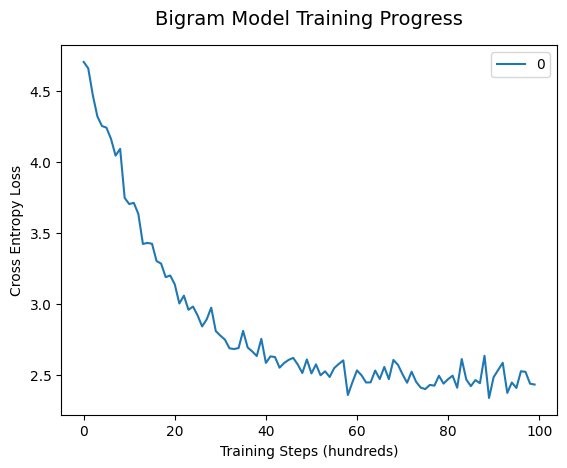

In [11]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(data=losses)
ax = sns.lineplot(data=df)

ax.set_xlabel('Training Steps (hundreds)', fontsize=10)
ax.set_ylabel('Cross Entropy Loss', fontsize=10)
ax.set_title('Bigram Model Training Progress', fontsize=14, pad=15)

In [12]:
print(decode(model.generate(inputs = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scace, tridesar, wnl'shenous s ls, theresseys
PlorseelapinghiybHen yof GLUCEN t l-t E:
I hisgothers je are!-e!
QLYotouciullle'z


We can see that even a simple bigram model can pickup some characteristics of the shakespeare dataset, as for example, that after punctuation it is most likely to have a new line.
However the generated language is still not readable. 
What is the biggest limitation here?

- The bigram assumption: The model cannot use the full context it is given, but looks only at the last preceeding character
- This motivates our next steps toward (attention) mechanisms, which will allow the model to consider all previous characters when making predictions.